In [1]:
!pip install visualkeras seaborn

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pathlib
import random
import os

from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
from IPython.display import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet152V2, ResNet101V2, EfficientNetB3, EfficientNetB7
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import visualkeras

In [3]:
tf.keras.backend.clear_session()

In [4]:
train_path = './data/Covid-19 Image Dataset/train'
test_path = './data/Covid-19 Image Dataset/test'

In [5]:
labels = os.listdir(train_path)
print(labels)

['Covid', 'Normal', 'Viral Pneumonia']


In [6]:
def load_random_imgs_from_folder(folder,label):
    plt.figure(figsize=(15,15))
    for i in range(3):
        file = random.choice(os.listdir(folder))
        image_path = os.path.join(folder, file)
        img=mpimg.imread(image_path)
        ax=plt.subplot(1,3,i+1)
        ax.title.set_text(label)
        plt.xlabel(f'Name: {file} , "Size: {img.shape}"')
        plt.imshow(img)

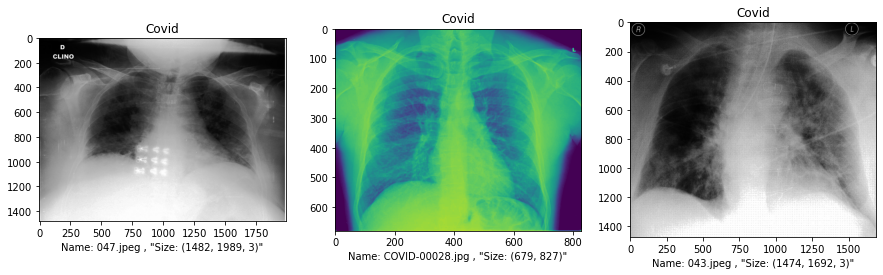

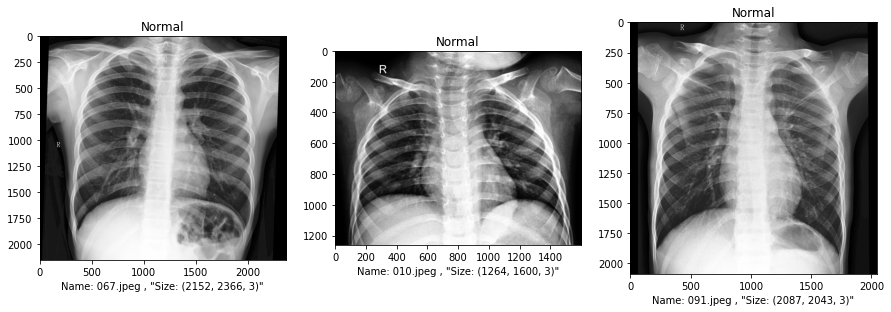

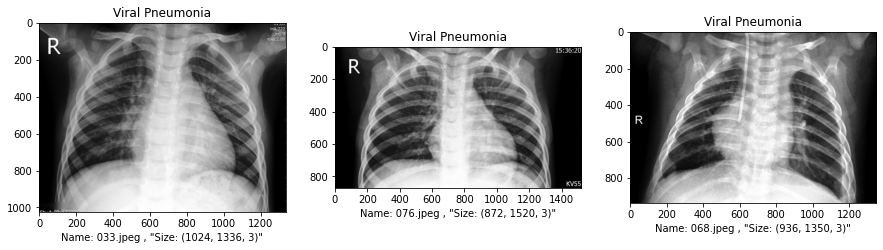

In [7]:
for label in labels:
    load_random_imgs_from_folder(f"{train_path}/{label}",label)

In [8]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   rotation_range = 0.5,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest'
                                  )

test_val_datagen = ImageDataGenerator(rescale = 1.0/255.0)

In [9]:
img_size = 512
batch = 16
train_generator = train_datagen.flow_from_directory(directory = train_path,
                                                    batch_size = batch,
                                                    class_mode = "categorical",
                                                    target_size = (img_size,img_size)
                                                    )
test_generator = test_val_datagen.flow_from_directory(directory = test_path,
                                                    batch_size = 1,
                                                    shuffle=False,
                                                    class_mode = "categorical",
                                                    target_size = (img_size,img_size)
                                                    )

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [10]:
base_model = EfficientNetB7(weights='imagenet', include_top=False, pooling='max',
                          input_shape=(img_size, img_size, 3)) 

# freeze extraction layers
base_model.trainable = True

# add custom top layers
x = base_model.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(len(labels), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# confirm unfrozen layers
for layer in model.layers:
    if layer.trainable==True:
        print(layer)

In [11]:
!pip install pydot

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 512, 512, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 512, 512, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 513, 513, 3)  0           ['normalization[0][0]']      

                                                                                                  
 block2a_expand_bn (BatchNormal  (None, 256, 256, 14  576        ['block2a_expand_conv[0][0]']    
 ization)                       4)                                                                
                                                                                                  
 block2a_expand_activation (Act  (None, 256, 256, 14  0          ['block2a_expand_bn[0][0]']      
 ivation)                       4)                                                                
                                                                                                  
 block2a_dwconv_pad (ZeroPaddin  (None, 257, 257, 14  0          ['block2a_expand_activation[0][0]
 g2D)                           4)                               ']                               
                                                                                                  
 block2a_d

 ization)                       2)                                                                
                                                                                                  
 block2c_expand_activation (Act  (None, 128, 128, 19  0          ['block2c_expand_bn[0][0]']      
 ivation)                       2)                                                                
                                                                                                  
 block2c_dwconv (DepthwiseConv2  (None, 128, 128, 19  1728       ['block2c_expand_activation[0][0]
 D)                             2)                               ']                               
                                                                                                  
 block2c_bn (BatchNormalization  (None, 128, 128, 19  768        ['block2c_dwconv[0][0]']         
 )                              2)                                                                
          

                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 64, 64, 288)  7200       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 64, 64, 288)  1152       ['block3b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3b_activation (Activation  (None, 64, 64, 288)  0          ['block3b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3b_s

 D)                                                                                               
                                                                                                  
 block4a_bn (BatchNormalization  (None, 32, 32, 288)  1152       ['block4a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4a_activation (Activation  (None, 32, 32, 288)  0          ['block4a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4a_se_squeeze (GlobalAver  (None, 288)         0           ['block4a_activation[0][0]']     
 agePooling2D)                                                                                    
          

                                                                                                  
 block4c_se_reshape (Reshape)   (None, 1, 1, 576)    0           ['block4c_se_squeeze[0][0]']     
                                                                                                  
 block4c_se_reduce (Conv2D)     (None, 1, 1, 24)     13848       ['block4c_se_reshape[0][0]']     
                                                                                                  
 block4c_se_expand (Conv2D)     (None, 1, 1, 576)    14400       ['block4c_se_reduce[0][0]']      
                                                                                                  
 block4c_se_excite (Multiply)   (None, 32, 32, 576)  0           ['block4c_activation[0][0]',     
                                                                  'block4c_se_expand[0][0]']      
                                                                                                  
 block4c_p

 block4e_se_expand (Conv2D)     (None, 1, 1, 576)    14400       ['block4e_se_reduce[0][0]']      
                                                                                                  
 block4e_se_excite (Multiply)   (None, 32, 32, 576)  0           ['block4e_activation[0][0]',     
                                                                  'block4e_se_expand[0][0]']      
                                                                                                  
 block4e_project_conv (Conv2D)  (None, 32, 32, 96)   55296       ['block4e_se_excite[0][0]']      
                                                                                                  
 block4e_project_bn (BatchNorma  (None, 32, 32, 96)  384         ['block4e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4e_d

 block5b_drop (Dropout)         (None, 32, 32, 136)  0           ['block5b_project_bn[0][0]']     
                                                                                                  
 block5b_add (Add)              (None, 32, 32, 136)  0           ['block5b_drop[0][0]',           
                                                                  'block5a_project_bn[0][0]']     
                                                                                                  
 block5c_expand_conv (Conv2D)   (None, 32, 32, 816)  110976      ['block5b_add[0][0]']            
                                                                                                  
 block5c_expand_bn (BatchNormal  (None, 32, 32, 816)  3264       ['block5c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5c_e

 block5e_expand_conv (Conv2D)   (None, 32, 32, 816)  110976      ['block5d_add[0][0]']            
                                                                                                  
 block5e_expand_bn (BatchNormal  (None, 32, 32, 816)  3264       ['block5e_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5e_expand_activation (Act  (None, 32, 32, 816)  0          ['block5e_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5e_dwconv (DepthwiseConv2  (None, 32, 32, 816)  20400      ['block5e_expand_activation[0][0]
 D)                                                              ']                               
          

 ivation)                       )                                                                 
                                                                                                  
 block6b_dwconv (DepthwiseConv2  (None, 16, 16, 1392  34800      ['block6b_expand_activation[0][0]
 D)                             )                                ']                               
                                                                                                  
 block6b_bn (BatchNormalization  (None, 16, 16, 1392  5568       ['block6b_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block6b_activation (Activation  (None, 16, 16, 1392  0          ['block6b_bn[0][0]']             
 )                              )                                                                 
          

 D)                             )                                ']                               
                                                                                                  
 block6d_bn (BatchNormalization  (None, 16, 16, 1392  5568       ['block6d_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block6d_activation (Activation  (None, 16, 16, 1392  0          ['block6d_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block6d_se_squeeze (GlobalAver  (None, 1392)        0           ['block6d_activation[0][0]']     
 agePooling2D)                                                                                    
          

 )                              )                                                                 
                                                                                                  
 block6f_activation (Activation  (None, 16, 16, 1392  0          ['block6f_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block6f_se_squeeze (GlobalAver  (None, 1392)        0           ['block6f_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6f_se_reshape (Reshape)   (None, 1, 1, 1392)   0           ['block6f_se_squeeze[0][0]']     
                                                                                                  
 block6f_s

 block7b_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block7b_se_squeeze[0][0]']     
                                                                                                  
 block7b_se_reduce (Conv2D)     (None, 1, 1, 96)     221280      ['block7b_se_reshape[0][0]']     
                                                                                                  
 block7b_se_expand (Conv2D)     (None, 1, 1, 2304)   223488      ['block7b_se_reduce[0][0]']      
                                                                                                  
 block7b_se_excite (Multiply)   (None, 16, 16, 2304  0           ['block7b_activation[0][0]',     
                                )                                 'block7b_se_expand[0][0]']      
                                                                                                  
 block7b_project_conv (Conv2D)  (None, 16, 16, 384)  884736      ['block7b_se_excite[0][0]']      
          

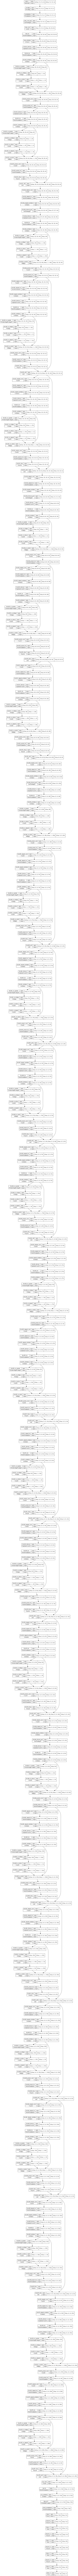

In [13]:
plot_model(model, to_file='./images/eff_model.png', show_shapes=True, show_layer_names=True)

In [14]:
visualkeras.layered_view(model, legend=True)

In [15]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20, verbose=1), 
             ModelCheckpoint('./models/eff_model.h5', save_best_only=True)]

In [16]:
opt = Adamax(learning_rate=0.001)
model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy']) 

In [17]:
DISABLE_GPU = True
if DISABLE_GPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [18]:
history = model.fit(train_generator,
                    epochs = 100,
                    validation_data = test_generator,
                    verbose = 1,
                    callbacks=callbacks)

Epoch 1/100


ResourceExhaustedError: Graph execution error:

Detected at node 'model/block2a_expand_activation/Sigmoid' defined at (most recent call last):
    File "D:\Miniconda3\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "D:\Miniconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "D:\Miniconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "D:\Miniconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "D:\Miniconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "D:\Miniconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "D:\Miniconda3\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "D:\Miniconda3\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "D:\Miniconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "D:\Miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "D:\Miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "D:\Miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "D:\Miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "D:\Miniconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "D:\Miniconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "D:\Miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2880, in run_cell
      result = self._run_cell(
    File "D:\Miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2935, in _run_cell
      return runner(coro)
    File "D:\Miniconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "D:\Miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3134, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "D:\Miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3337, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "D:\Miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3397, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\lebro\AppData\Local\Temp\ipykernel_19796\1948753392.py", line 1, in <cell line: 1>
      history = model.fit(train_generator,
    File "D:\Miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "D:\Miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "D:\Miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "D:\Miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\Miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "D:\Miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "D:\Miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "D:\Miniconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\Miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "D:\Miniconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "D:\Miniconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "D:\Miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "D:\Miniconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\Miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "D:\Miniconda3\envs\tf\lib\site-packages\keras\layers\core\activation.py", line 57, in call
      return self.activation(inputs)
    File "D:\Miniconda3\envs\tf\lib\site-packages\keras\activations.py", line 270, in swish
      return tf.nn.silu(x)
Node: 'model/block2a_expand_activation/Sigmoid'
failed to allocate memory
	 [[{{node model/block2a_expand_activation/Sigmoid}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_29182]

In [ ]:
model = load_model('./models/eff_model.h5')

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()

In [ ]:
tr_plot(history, 0)

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print('Loss: %.3f' % (test_loss * 100.0))
print('Accuracy: %.3f' % (test_acc * 100.0)) 

In [ ]:
predictions = np.argmax(model.predict(test_generator),axis=1)
labels = test_generator.classes
predictions , labels

In [ ]:
def fbeta(y_true, y_pred, threshold_shift=0):
    beta_squared = 4

    y_pred = K.clip(y_pred, 0, 1)
 
    y_pred_bin = K.round(y_pred + threshold_shift)
 
    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
 
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
 
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

In [ ]:
def confusion_matrix_plot(matrix):
    plt.figure(figsize=(12,10))
    cmap = "YlGnBu"
    ax= plt.subplot()
    sns.heatmap(matrix, annot=True, fmt='g', ax=ax, cmap=cmap);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    plt.savefig('./images/con_mat.png')
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(classes); 
    ax.yaxis.set_ticklabels(classes[::-1]);
    plt.show()

In [ ]:
def cal_score(model, plot=True):
    matrix = confusion_matrix(predictions, labels)
    print(matrix)
    print('\n')

    f1 = f1_score(predictions, labels, average='weighted')
    print(f'F1 Score: {f1}')
    print('\n')
    
    print(classification_report(predictions, labels, target_names=classes))
    
    if plot:
        confusion_matrix_plot(matrix)

In [ ]:
classes = []
for i in os.listdir(test_path):
    classes += [i]

print(classes)

In [ ]:
cal_score(model, plot=True)